## Training XGboost regression model

In [6]:
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read in all merged csv data files
path = r'../data/curated/merged_dataset/'
all_files = glob.glob(os.path.join(path , "*.csv"))

# merge all data of different years
li = []

for filename in sorted(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

merged_df = pd.concat(li, axis=0, ignore_index=True)

# Rename the columns to facilitate to call them for later
merged_df.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)

ECON_COLS = ['saving_rate', 'population_density', 'income_per_person', 'crime_cases', 'gdp']

DIST_COLS = ['min_distance_to_prim', 'min_distance_to_poli', 'min_distance_to_park', 'min_distance_to_second', 'min_distance_to_hosp', 'min_distance_to_cbd', 
'min_distance_to_shop', 'min_distance_to_train']

INTERNAL_COLS = ['nbed', 'nbath', 'ncar']

all_candidates = (DIST_COLS+INTERNAL_COLS).copy() # only select from distances

categorical_features = ['nbed', 'nbath', 'ncar', 'residence_type', 'sa2_2021']
le = LabelEncoder()

# Convert the categorical variables to numerical
for i in range(len(categorical_features)):
    new = le.fit_transform(merged_df[categorical_features[i]])
    merged_df[categorical_features[i]] = new


merged_df.drop(['address', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1, inplace=True)
merged_df.dropna(inplace=True)
merged_df  

,year,sa2_2021,residence_type,nbed,nbath,ncar,min_distance_to_cbd,min_distance_to_park,min_distance_to_prim,min_distance_to_second,min_distance_to_train,min_distance_to_hosp,min_distance_to_poli,min_distance_to_shop,weekly_rent,gdp,saving_rate,income_per_person,population_density,crime_cases
0,2013,61,1,1,0,0,227.97163,23.16035,7.35747,16.96507,35.56825,21.35025,22.04660,9.35209,300.0,1536454,6.861393,39683.563449,2.172408,86.0
1,2013,102,1,1,0,0,223.66084,5.71742,6.50536,6.76794,7.54355,7.42972,6.28177,9.35209,215.0,1536454,6.861393,47222.702327,5.425503,36.0
2,2013,61,1,1,0,0,243.25680,5.11222,0.20027,36.72106,50.85341,36.63541,0.08478,9.35209,175.0,1536454,6.861393,39683.563449,2.172408,86.0
3,2013,23,1,5,2,0,140.35827,78.32509,10.66523,11.91899,11.26906,177.44731,84.47341,9.35209,350.0,1536454,6.861393,43556.283562,473.765281,1288.0
4,2013,209,0,0,0,0,13.86135,0.93250,1.32931,3.49174,2.20800,177.44731,84.47341,3.96501,275.0,1536454,6.861393,86103.411528,2834.210526,1923.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172030,2022,89,1,3,0,1,293.28053,0.56012,1.21809,114.77016,90.08591,140.56888,74.35608,13.64920,265.0,3305754,12.839000,54365.266130,402.000000,281.0
172031,2022,504,1,3,2,2,258.29111,3.49087,5.08707,3.60570,8.37185,2.60312,74.35608,13.64920,500.0,3305754,12.839000,60828.473189,689.000000,3049.0
172032,2022,190,1,1,2,1,9.47077,2.45011,1.33931,1.62322,3.63291,140.56888,74.35608,1.97636,750.0,3305754,12.839000,98756.492866,3656.000000,759.0
172033,2022,133,0,0,0,1,1.84933,0.65199,1.10438,1.27940,1.87840,140.56888,74.35608,13.64920,409.0,3305754,12.839000,71305.473808,5791.000000,1788.0


In [3]:
# seperate predictors and response variables, after experiments, according to the model accuracy, log(y) fits more into the model, rather than y
y = merged_df['weekly_rent']
y = np.log(y)
X = merged_df.loc[:, merged_df.columns != 'weekly_rent']

Null Training R2 = 0.5454423563005244
Null Training MSE = 0.06640420185412099


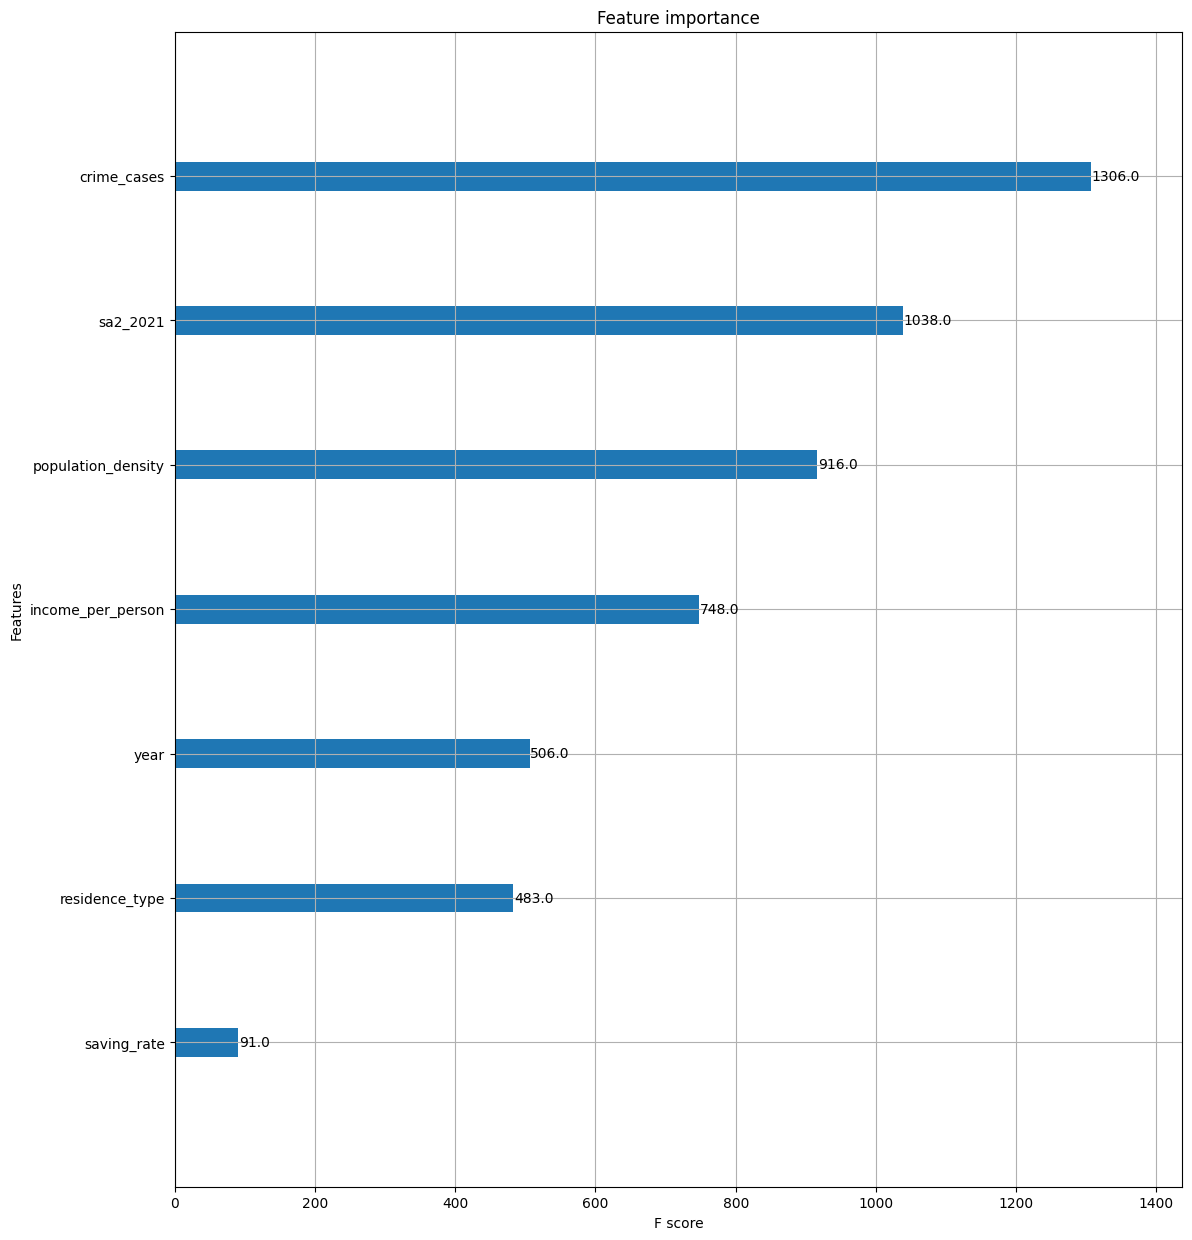

In [10]:
# holdout method to split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_null = X_train.drop(DIST_COLS+INTERNAL_COLS, axis=1) # By default, all categorical variables are used, plus economic factors

# build XGBoost regression model
# https://machinelearningmastery.com/xgboost-for-regression/
model = XGBRegressor()
model.fit(X_null, y_train)

predict_null = model.predict(X_null)
print(f'Null Training R2 = {r2_score(y_train, predict_null)}')
print(f'Null Training MSE = {mean_squared_error(y_train, predict_null)}')

# plot feature importance graph
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
fig = plt.figure(figsize=(13, 15))
ax = fig.add_subplot(1, 1, 1)

plot_importance(model, ax=ax)
plt.show()

In [11]:
# Forward selection with lowest Mean Squared Error
mse_dict = {}
last_min = mean_squared_error(y_train, predict_null)
candidates = []

while(True):
    for x in all_candidates:
        print(f"trying feature {x}")
        new_X = X_train[x]
        forward_X = pd.concat([new_X, X_null], axis=1)
        model = XGBRegressor().fit(forward_X, y_train)
        temp_predict = model.predict(forward_X)
        mse_dict[x] = mean_squared_error(y_train, temp_predict)
        print(f"Training mse = {mean_squared_error(y_train, temp_predict)}")

    min_mse =  min(mse_dict.values())
    min_mse_key = min(mse_dict, key=mse_dict.get)

    if min_mse < last_min:
        candidates.append(min_mse_key)
        all_candidates.remove(min_mse_key)
        last_min = min_mse
        X_null = pd.concat([X_train[min_mse_key], X_null], axis=1)

        print('step: ' + str(len(candidates)))
        print(candidates)
        print('new Training mse: ' + str(min_mse))
        print('===============')
    else:
        model = XGBRegressor().fit(X_null, y_train)
        final_prediction = model.predict(X_null)
        r2 = r2_score(y_train, final_prediction)
        mse = mean_squared_error(y_train, final_prediction)
        print(f"Selected Model R2 = {r2}, MSE = {mse}")
        break

trying feature min_distance_to_prim
Training mse = 0.06103688656734322
trying feature min_distance_to_poli
Training mse = 0.06227885538589118
trying feature min_distance_to_park
Training mse = 0.061742191051550974
trying feature min_distance_to_second
Training mse = 0.06070942899044764
trying feature min_distance_to_hosp
Training mse = 0.06367795508122193
trying feature min_distance_to_cbd
Training mse = 0.06078622148324768
trying feature min_distance_to_shop
Training mse = 0.06514861751396951
trying feature min_distance_to_train
Training mse = 0.061581308210366364
trying feature nbed
Training mse = 0.0485367728658118
trying feature nbath
Training mse = 0.0552671292133269
trying feature ncar
Training mse = 0.05979029291101523
step: 1
['nbed']
new Training mse: 0.0485367728658118
trying feature min_distance_to_prim
Training mse = 0.04542693939634699
trying feature min_distance_to_poli
Training mse = 0.046161299552065854
trying feature min_distance_to_park
Training mse = 0.04561864912688

In [12]:
SELECTED_FEATURES = set(candidates)
sorted(SELECTED_FEATURES)

['min_distance_to_cbd',
 'min_distance_to_hosp',
 'min_distance_to_park',
 'min_distance_to_prim',
 'min_distance_to_second',
 'min_distance_to_train',
 'nbath',
 'nbed',
 'ncar']

In [22]:
# calculate the training and testing accuracy of the xgboost regression model
drop = list(set(DIST_COLS).union(INTERNAL_COLS) - SELECTED_FEATURES)
final_model = XGBRegressor().fit(X_train.drop(drop, axis=1), y_train)
test_prediction = final_model.predict(X_test.drop(drop, axis=1))
test_r2 = r2_score(y_test, test_prediction)
test_mse = mean_squared_error(y_test, test_prediction)
print('Accuracy of xgboost regression model on training set:{}'.format(final_model.score(X_train.drop(drop, axis=1), y_train)))
print(f"Accuracy of xgboost regression model on testing set: {test_r2}, MSE = {test_mse}")

Accuracy of xgboost regression model on training set:0.7416471436707428
Accuracy of xgboost regression model on testing set: 0.6966642168135669, MSE = 0.04401306936545925


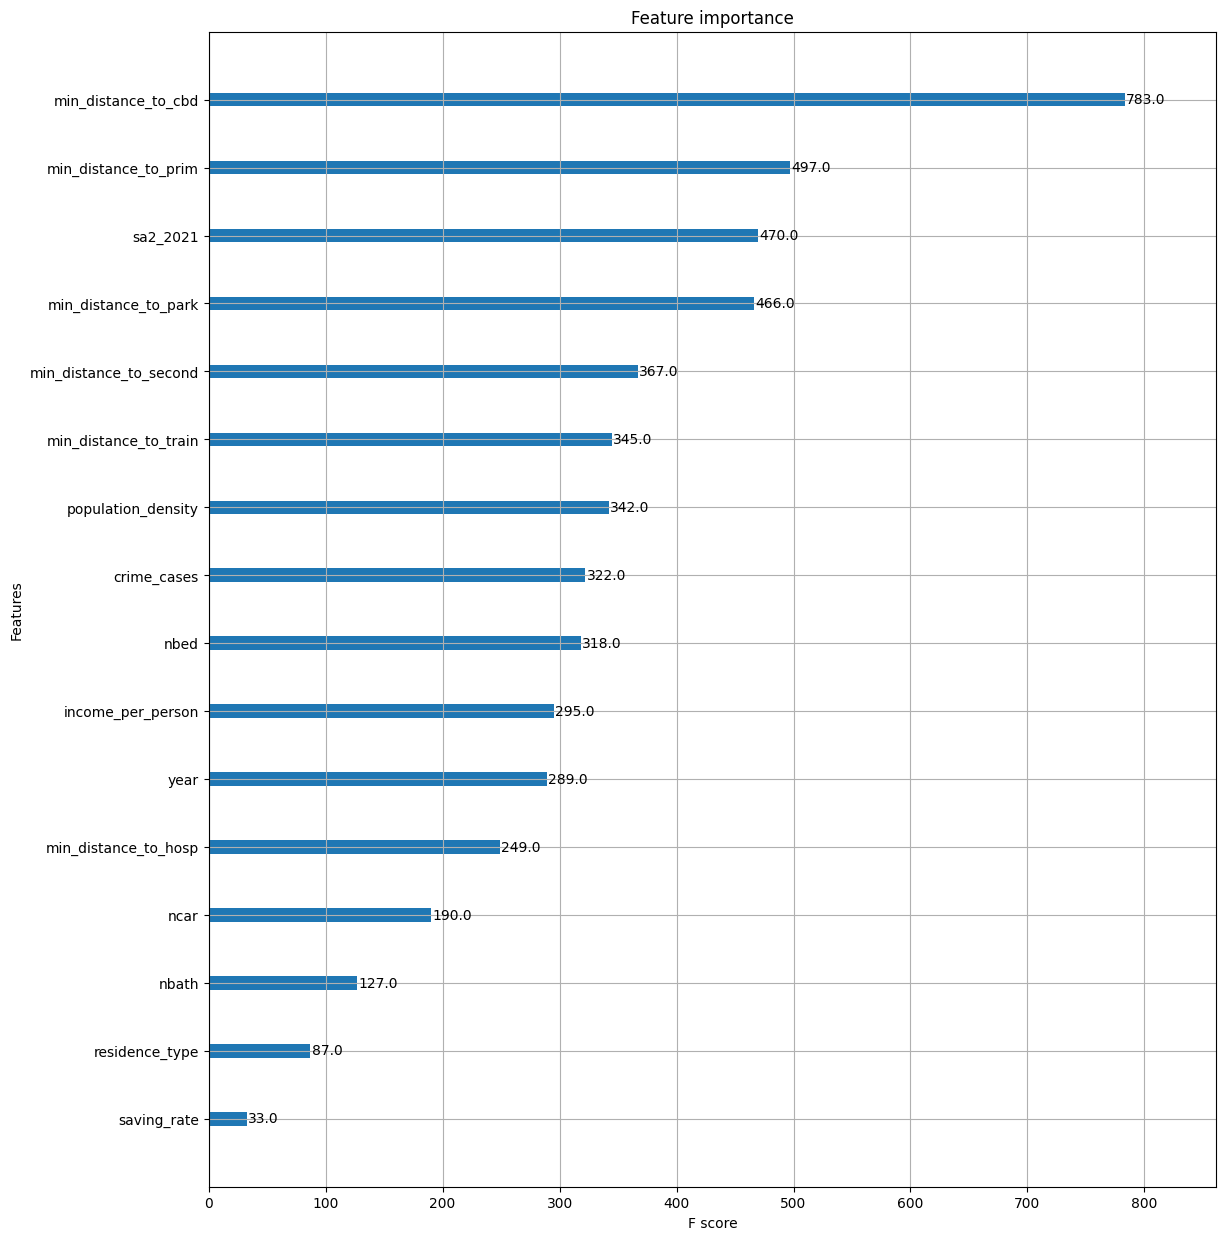

In [20]:
# plot feature importance graph of final model
fig = plt.figure(figsize=(13, 15))
ax = fig.add_subplot(1, 1, 1)

plot_importance(final_model, ax=ax)
plt.show()

## Make prediction for 2023 - 2027

In [23]:
# training the XGboost regression model by all 2013 - 2022 data
model_final = XGBRegressor()
model_final.fit(X.drop(drop, axis=1), y)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [10]:
import pickle
pickle.dump(model_final, open('../web/models/xgboost_rental_model.pkl','wb'))
model = pickle.load(open('../web/models/xgboost_rental_model.pkl','rb'))

In [25]:
# create path
new_path = '../data/curated/2023_2027_rental_prediction_xgboost/'

if not os.path.exists(new_path):
    os.makedirs(new_path)

# predicting rent prices for 2023 -  2027
YEARS = [2023, 2024, 2025, 2026, 2027]

for year in YEARS:
    prediction_set = pd.read_csv(f'../data/curated/2023_2027_data/{year}_data.csv')
    prediction = prediction_set.copy()
    prediction_set.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)

    categorical_features = ['nbed', 'nbath', 'ncar', 'residence_type', 'sa2_2021']
    le = LabelEncoder()

    # Convert the categorical variables to numerical
    for i in range(len(categorical_features)):
        new = le.fit_transform(prediction_set[categorical_features[i]])
        prediction_set[categorical_features[i]] = new
    
    prediction_set.dropna(inplace=True)

    pred_rent = np.exp(model_final.predict(prediction_set.drop(drop, axis=1)))
    prediction['predicted_price'] = pred_rent
    prediction.to_csv(f'../data/curated/2023_2027_rental_prediction_xgboost/{year}_rental.csv', index=False)